# A ConvNet for the 2020s

## Research Paper Link : https://arxiv.org/pdf/2201.03545

Loading CIFAR-10...


100%|██████████| 170M/170M [00:02<00:00, 70.6MB/s]


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Training...
Epoch 1/5 | Loss: 1.5086 | Acc: 45.39%
Epoch 2/5 | Loss: 1.1538 | Acc: 58.57%
Epoch 3/5 | Loss: 0.9471 | Acc: 66.48%
Epoch 4/5 | Loss: 0.7580 | Acc: 73.34%
Epoch 5/5 | Loss: 0.5692 | Acc: 79.94%
Test Accuracy: 65.56%


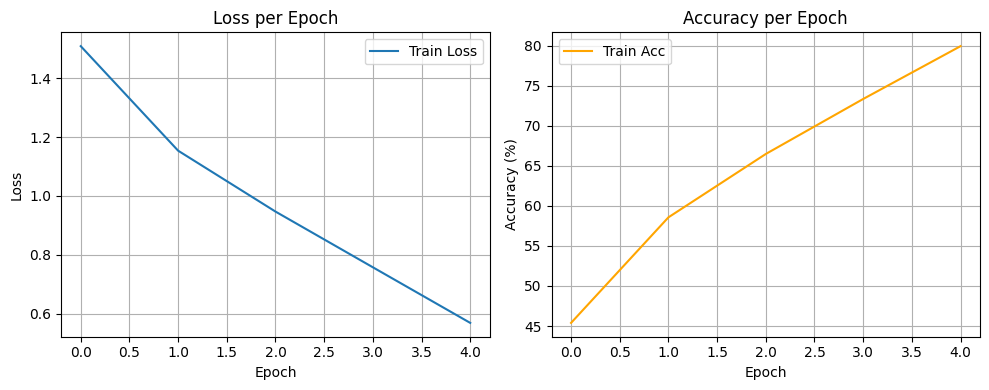

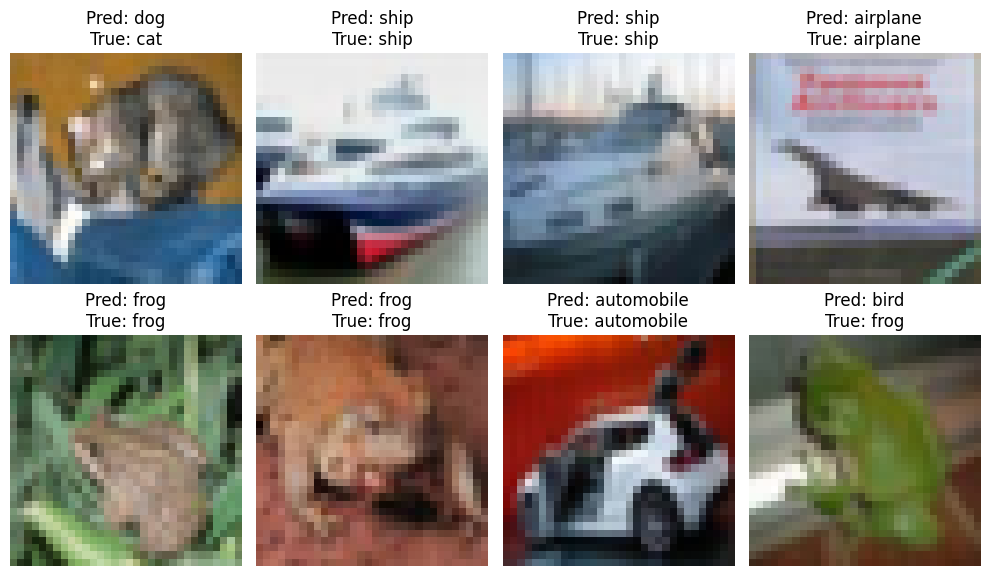

In [1]:
# ----------------------------------------------------------
# Mini-ConvNeXt: A Didactic Replication of
# "A ConvNet for the 2020s" (Liu et al., 2022)
# ----------------------------------------------------------
# Educational, end-to-end script:
#   CIFAR-10 -> Mini-ConvNeXt -> Train -> Evaluate -> Predict+Visualize
#
# Key ConvNeXt ideas mapped in this mini version:
#   - Patchify stem (4x4, stride 4) instead of classic 7x7+maxpool:contentReference[oaicite:1]{index=1}
#   - Depthwise convolution (large kernel 7x7) for spatial mixing:contentReference[oaicite:2]{index=2}
#   - Inverted bottleneck MLP (expand x4 -> GELU -> project):contentReference[oaicite:3]{index=3}
#   - LayerNorm (channels-last) instead of BatchNorm:contentReference[oaicite:4]{index=4}
#   - Fewer activations/norms (Transformer-style minimalism):contentReference[oaicite:5]{index=5}
#   - Separate downsampling layers between stages:contentReference[oaicite:6]{index=6}
# This is a tiny 2-stage variant suitable for CIFAR-10 (32x32).
# ----------------------------------------------------------

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# ==========================================================
# 1) Dataset: CIFAR-10 (simple + standard normalize)
# ==========================================================
print("Loading CIFAR-10...")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

classes = train_dataset.classes
print("Classes:", classes)

# ==========================================================
# 2) Mini-ConvNeXt Model
#    - Patchify stem (4x4/4):contentReference[oaicite:7]{index=7}
#    - ConvNeXt Block: DW-Conv(7x7) -> LN -> 1x1 expand(4x) -> GELU -> 1x1 project -> Residual:contentReference[oaicite:8]{index=8}
#    - Downsample between stages with LN + 2x2/2 conv:contentReference[oaicite:9]{index=9}
# ==========================================================

class LayerNormChannelsLast(nn.Module):
    """
    LayerNorm applied over channel dimension in channels-last format.
    We permute (N,C,H,W) -> (N,H,W,C), apply LN over C, then revert.
    """
    def __init__(self, num_channels, eps=1e-6):
        super().__init__()
        self.ln = nn.LayerNorm(num_channels, eps=eps)

    def forward(self, x):
        # x: (N, C, H, W)
        x = x.permute(0, 2, 3, 1)            # (N, H, W, C)
        x = self.ln(x)
        x = x.permute(0, 3, 2, 1)            # (N, C, W, H)
        x = x.permute(0, 1, 3, 2)            # back to (N, C, H, W)
        return x

class ConvNeXtBlock(nn.Module):
    """
    ConvNeXt block (tiny-form):
      - Depthwise Conv (7x7):contentReference[oaicite:10]{index=10}
      - LayerNorm (channels-last):contentReference[oaicite:11]{index=11}
      - Pointwise 1x1 (expand 4x) -> GELU -> Pointwise 1x1 (project):contentReference[oaicite:12]{index=12}
      - Residual
    Uses 'fewer activations/norms' style (minimal):contentReference[oaicite:13]{index=13}.
    """
    def __init__(self, dim, kernel_size=7, mlp_ratio=4.0):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=kernel_size, padding=kernel_size//2, groups=dim)  # depthwise
        self.ln = LayerNormChannelsLast(dim)  # LayerNorm instead of BN
        hidden_dim = int(dim * mlp_ratio)
        self.pwconv1 = nn.Conv2d(dim, hidden_dim, kernel_size=1)  # expand
        self.act = nn.GELU()                                       # GELU:contentReference[oaicite:14]{index=14}
        self.pwconv2 = nn.Conv2d(hidden_dim, dim, kernel_size=1)  # project

    def forward(self, x):
        residual = x
        x = self.dwconv(x)
        x = self.ln(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        return x + residual

class PatchifyStem(nn.Module):
    """
    Patchify stem: 4x4 conv, stride 4 -> token-like patches:contentReference[oaicite:15]{index=15}.
    """
    def __init__(self, in_ch=3, out_ch=96, patch=4):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=patch, stride=patch)

    def forward(self, x):
        return self.conv(x)

class DownsampleLayer(nn.Module):
    """
    Separate downsampling between stages with LN then 2x2/2 conv (channels increase):contentReference[oaicite:16]{index=16}.
    """
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.ln = LayerNormChannelsLast(in_ch)
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=2, stride=2)

    def forward(self, x):
        x = self.ln(x)
        x = self.conv(x)
        return x

class MiniConvNeXt(nn.Module):
    """
    A tiny 2-stage ConvNeXt for CIFAR-10:
      - Stem: 4x4/4 -> 96 ch
      - Stage 1: [ConvNeXtBlock x 2] @ 96 ch
      - Downsample: LN + 2x2/2 -> 192 ch
      - Stage 2: [ConvNeXtBlock x 2] @ 192 ch
      - Head: LN -> global avg -> linear(192->10)
    This embodies the paper’s modernization steps in a compact form:contentReference[oaicite:17]{index=17}.
    """
    def __init__(self, num_classes=10, dims=(96, 192), blocks=(2, 2), kernel_size=7):
        super().__init__()
        c1, c2 = dims

        # Stem (patchify)
        self.stem = PatchifyStem(in_ch=3, out_ch=c1, patch=4)  # 32x32 -> 8x8 tokens in feature map

        # Stage 1
        self.stage1 = nn.Sequential(*[ConvNeXtBlock(c1, kernel_size=kernel_size) for _ in range(blocks[0])])

        # Downsample 1
        self.down1 = DownsampleLayer(c1, c2)

        # Stage 2
        self.stage2 = nn.Sequential(*[ConvNeXtBlock(c2, kernel_size=kernel_size) for _ in range(blocks[1])])

        # Head
        self.head_norm = LayerNormChannelsLast(c2)  # LN after final stage:contentReference[oaicite:18]{index=18}
        self.head_fc = nn.Linear(c2, num_classes)

    def forward(self, x):
        x = self.stem(x)       # (N, 96, 8, 8)
        x = self.stage1(x)     # stage 1
        x = self.down1(x)      # (N, 192, 4, 4)
        x = self.stage2(x)     # stage 2
        x = self.head_norm(x)
        x = x.mean(dim=[2,3])  # global average pooling
        x = self.head_fc(x)
        return x

# ==========================================================
# 3) Training
# ==========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MiniConvNeXt(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)  # AdamW as in the paper’s recipe family:contentReference[oaicite:19]{index=19}

num_epochs = 5
train_loss_history, train_acc_history = [], []

print("Training...")
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad(set_to_none=True)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc  = 100.0 * correct / total
    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_acc)
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}%")

# ==========================================================
# 4) Evaluation
# ==========================================================
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

test_acc = 100.0 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

# ==========================================================
# 5) Visualizations: Curves + Predictions
# ==========================================================
# Training curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_loss_history, label="Train Loss")
plt.title("Loss per Epoch"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_acc_history, label="Train Acc", color="orange")
plt.title("Accuracy per Epoch"); plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()

# Predictions on a sample of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, predicted = outputs.max(1)

def imshow(img, title):
    img = img / 2 + 0.5   # unnormalize for display (since we normalized to mean=0.5, std=0.5)
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(10,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    imshow(images[i].cpu(), f"Pred: {classes[predicted[i]]}\nTrue: {classes[labels[i]]}")
plt.tight_layout()
plt.show()


In [2]:
model

MiniConvNeXt(
  (stem): PatchifyStem(
    (conv): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
  )
  (stage1): Sequential(
    (0): ConvNeXtBlock(
      (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
      (ln): LayerNormChannelsLast(
        (ln): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
      )
      (pwconv1): Conv2d(96, 384, kernel_size=(1, 1), stride=(1, 1))
      (act): GELU(approximate='none')
      (pwconv2): Conv2d(384, 96, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): ConvNeXtBlock(
      (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
      (ln): LayerNormChannelsLast(
        (ln): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
      )
      (pwconv1): Conv2d(96, 384, kernel_size=(1, 1), stride=(1, 1))
      (act): GELU(approximate='none')
      (pwconv2): Conv2d(384, 96, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (down1): DownsampleLayer(
    (ln): LayerNormChannels

In [3]:
!pip install -q torchinfo

In [4]:
from torchinfo import summary

In [5]:
summary(
    model=model,                     # your model (e.g., MiniConvNeXt or MiniSwin)
    input_size=(1, 3, 32, 32),       # batch=1, 3-channel RGB, 32x32 image
    col_names=("input_size", "output_size", "num_params", "trainable"),
    col_width=20,                    # widen columns for readability
    row_settings=("var_names",)      # show variable (layer) names for clarity
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
MiniConvNeXt (MiniConvNeXt)                   [1, 3, 32, 32]       [1, 10]              --                   True
├─PatchifyStem (stem)                         [1, 3, 32, 32]       [1, 96, 8, 8]        --                   True
│    └─Conv2d (conv)                          [1, 3, 32, 32]       [1, 96, 8, 8]        4,704                True
├─Sequential (stage1)                         [1, 96, 8, 8]        [1, 96, 8, 8]        --                   True
│    └─ConvNeXtBlock (0)                      [1, 96, 8, 8]        [1, 96, 8, 8]        --                   True
│    │    └─Conv2d (dwconv)                   [1, 96, 8, 8]        [1, 96, 8, 8]        4,800                True
│    │    └─LayerNormChannelsLast (ln)        [1, 96, 8, 8]        [1, 96, 8, 8]        192                  True
│    │    └─Conv2d (pwconv1)                  [1, 96, 8, 8]        [1, 384, 8, 8]  